In [25]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

# Set initial seed for random sampling
rng = np.random.default_rng(5731)

In [2]:
# Load in dataset and set up new columns
data = pd.read_csv('zaw_table_4.csv').sort_values(by=['sigma'])

# Divide by factor of 200 to scale velocity dispersion according to paper
data['sigma'] /= 200 
data['e_sigma'] /= 200

# Multiply by factor of 10^7 to scale black hole mass according to paper
data['MassBH'] *= 1E7 
data['E_MassBH'] *= 1E7
data['e_MassBH'] *= 1E7

# Set up intercept
data['Intercept'] = np.ones(data['Name'].count())
data['e_Intercept'] = np.ones(data['Name'].count())*1e-2

# Convert to log velocity dispersion and keep only the largest log error
data['log_sigma'] = np.log10(data['sigma'])
data['e_log_sigma_upper'] = np.log10(1 + data['e_sigma']/data['sigma'])
data['e_log_sigma_lower'] = -np.log10(1 - data['e_sigma']/data['sigma'])
data['e_log_sigma'] = data[['e_log_sigma_upper', 'e_log_sigma_lower']].max(axis=1)

# Compute square of log velocity dispersion and propagate (gaussian) error
data['log_sigma^2'] = np.log10(data['sigma'])**2
data['e_log_sigma^2'] = 2*np.abs(data['log_sigma'])*data['e_log_sigma']

# Convert to log black hole mass and keep only the largest log error
data['log_MassBH'] = np.log10(data['MassBH'])
data['e_log_MassBH_upper'] = np.log10(1 + data['E_MassBH']/data['MassBH'])
data['e_log_MassBH_lower'] = -np.log10(1 - data['e_MassBH']/data['MassBH'])
data['e_log_MassBH'] = data[['e_log_MassBH_upper', 'e_log_MassBH_lower']].max(axis=1)

# Set up response and error for linear model
X = np.array(data[['Intercept', 'log_sigma']])
X_err = np.array(data[['e_Intercept', 'e_log_sigma']])

# Set up response and error for quadratic model
X_q = np.array(data[['Intercept', 'log_sigma', 'log_sigma^2']])
X_q_err = np.array(data[['e_Intercept', 'e_log_sigma', 'e_log_sigma^2']])

# Set up covariate and error for both models
Y = np.array(data['log_MassBH'])
Y_err = np.array(data['e_log_MassBH'])

### Errorbar Plot of Dataset

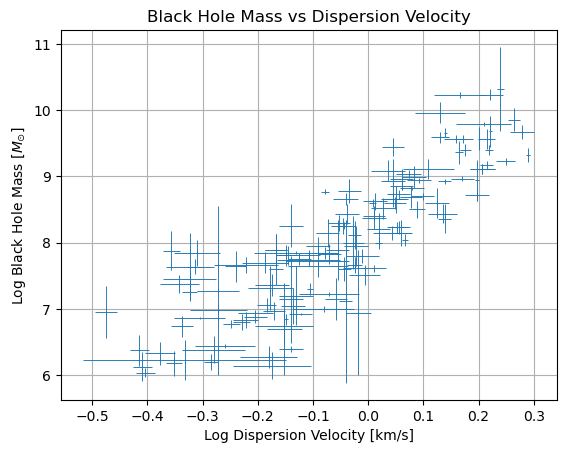

In [3]:
plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.grid()
plt.title('Black Hole Mass vs Dispersion Velocity')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.show()

# Linear Regression

In [4]:
# def linear_regression(X, Y, m=0, c=1e2, samples=10000, draws=50):
#     coords = {
#         'galaxy': range(X.shape[0]),
#         'parameters': ['Intercept', 'Sigma'],
#     }

#     with pm.Model(coords=coords):
#         x = pm.Data('Sigma', X, dims=['galaxy', 'parameters'])

#         # Model parameters
#         betas = pm.Normal('beta', mu=m, sigma=c, dims='parameters')
#         epsilon = pm.HalfNormal('epsilon', sigma=c)

#         # Model
#         mu = pm.Deterministic('mu', x @ betas)

#         # Likelihood
#         y = pm.Normal('MassBH', mu=mu, sigma=epsilon, observed=Y)

#         # Sample posterior
#         trace = pm.sample(samples)
#         prior_pred = pm.sample_prior_predictive(draws=draws, random_seed=rng)
#         post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
#         return trace, prior_pred, post_pred

In [5]:
# # Apply the linear regression model and show table of results
# l_trace, l_prior_pred, l_post_pred = linear_regression(X, Y)
# pm.summary(l_trace)

### Posterior Plot

In [6]:
# # Calculate quantiles for posterior black hole mass data
# Y_mean = np.quantile(l_trace.posterior.mu.values, 0.50, axis=(0, 1))
# Y_lower = np.quantile(l_trace.posterior.mu.values, 0.025, axis=(0, 1))
# Y_upper = np.quantile(l_trace.posterior.mu.values, 0.975, axis=(0, 1))

# plt.figure()
# plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
#              data['e_log_sigma'], fmt='none', elinewidth=0.66)
# plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
# plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
# plt.title('Linear Regression Posterior')
# plt.xlabel(r'Log Dispersion Velocity [km/s]')
# plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
# plt.grid()
# plt.show()

### Posterior Predictive Check

In [7]:
# # Calculate quantiles for posterior predictive black hole mass data
# Y_mean = np.quantile(l_post_pred.posterior_predictive.MassBH.values, 0.50, axis=(0, 1))
# Y_lower = np.quantile(l_post_pred.posterior_predictive.MassBH.values, 0.025, axis=(0, 1))
# Y_upper = np.quantile(l_post_pred.posterior_predictive.MassBH.values, 0.975, axis=(0, 1))

# plt.figure()
# plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
#              data['e_log_sigma'], fmt='none', elinewidth=0.66)
# plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
# plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
# plt.title('Linear Regression Posterior Predictive')
# plt.xlabel(r'Log Dispersion Velocity [km/s]')
# plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
# plt.grid()
# plt.show()

### Prior Predictive Check

In [8]:
# # Calculate quantiles for prior predictive black hole mass data
# Y_mean = np.quantile(l_prior_pred.prior_predictive.MassBH.values, 0.50, axis=(0, 1))
# Y_lower = np.quantile(l_prior_pred.prior_predictive.MassBH.values, 0.025, axis=(0, 1))
# Y_upper = np.quantile(l_prior_pred.prior_predictive.MassBH.values, 0.975, axis=(0, 1))

# plt.figure()
# plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
#              data['e_log_sigma'], fmt='none', elinewidth=0.66)
# plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
# plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
# plt.title('Linear Regression Prior Predictive')
# plt.xlabel(r'Log Dispersion Velocity [km/s]')
# plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
# plt.grid()
# plt.show()

# Quadratic Regression

In [9]:
# def quadratic_regression(X, Y, m=0, c=1e2, samples=10000, draws=50):
#     coords = {
#         'galaxy': range(X.shape[0]),
#         'parameters': ['Intercept', 'Sigma', 'Sigma^2'],
#     }

#     with pm.Model(coords=coords):
#         x = pm.Data('Sigma', X, dims=['galaxy', 'parameters'])

#         # Model parameters
#         betas = pm.Normal('beta', mu=m, sigma=c, dims='parameters')
#         epsilon = pm.HalfNormal('epsilon', sigma=c)

#         # Model
#         mu = pm.Deterministic('mu', x @ betas)

#         # Likelihood
#         y = pm.Normal('MassBH', mu=mu, sigma=epsilon, observed=Y)

#         # Sample posterior
#         trace = pm.sample(samples)
#         prior_pred = pm.sample_prior_predictive(draws=draws, random_seed=rng)
#         post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
#         return trace, prior_pred, post_pred

In [10]:
# # Apply the quadratic regression model and show table of results
# q_trace, q_prior_pred, q_post_pred = quadratic_regression(X_q, Y)
# pm.summary(q_trace)

### Posterior Plot

In [11]:
# # Calculate quantiles for posterior black hole mass data
# Y_mean = np.quantile(q_trace.posterior.mu.values, 0.50, axis=(0, 1))
# Y_lower = np.quantile(q_trace.posterior.mu.values, 0.025, axis=(0, 1))
# Y_upper = np.quantile(q_trace.posterior.mu.values, 0.975, axis=(0, 1))

# plt.figure()
# plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
#              data['e_log_sigma'], fmt='none', elinewidth=0.66)
# plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
# plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
# plt.title('Quadratic Regression Posterior')
# plt.xlabel(r'Log Dispersion Velocity [km/s]')
# plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
# plt.grid()
# plt.show()

### Posterior Predictive Check

In [12]:
# # Calculate quantiles for posterior predictive black hole mass data
# Y_mean = np.quantile(q_post_pred.posterior_predictive.MassBH.values, 0.50, axis=(0, 1))
# Y_lower = np.quantile(q_post_pred.posterior_predictive.MassBH.values, 0.025, axis=(0, 1))
# Y_upper = np.quantile(q_post_pred.posterior_predictive.MassBH.values, 0.975, axis=(0, 1))

# plt.figure()
# plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
#              data['e_log_sigma'], fmt='none', elinewidth=0.66)
# plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
# plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
# plt.title('Quadratic Regression Posterior Predictive')
# plt.xlabel(r'Log Dispersion Velocity [km/s]')
# plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
# plt.grid()
# plt.show()

### Prior Predictive Check

In [13]:
# # Calculate quantiles for prior predictive black hole mass data
# Y_mean = np.quantile(q_prior_pred.prior_predictive.MassBH.values, 0.50, axis=(0, 1))
# Y_lower = np.quantile(q_prior_pred.prior_predictive.MassBH.values, 0.025, axis=(0, 1))
# Y_upper = np.quantile(q_prior_pred.prior_predictive.MassBH.values, 0.975, axis=(0, 1))

# plt.figure()
# plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
#              data['e_log_sigma'], fmt='none', elinewidth=0.66)
# plt.plot(data['log_sigma'], Y_mean, color='red', label='Normal Best-fit Line')
# plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
# plt.title('Quadratic Regression Prior Predictive')
# plt.xlabel(r'Log Dispersion Velocity [km/s]')
# plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
# plt.grid()
# plt.show()

# Linear Regression with Measurement Error

In [14]:
def me_linear_regression(X, Y, X_std, Y_std, c=1e-3, d=1e-3, e=0.5, f=0.5, samples=10000, draws=50):
    coords = {
        'galaxy': range(X.shape[0]),
        'parameters': ['Intercept', 'Sigma'],
    }
    
    with pm.Model(coords=coords):
        tau = pm.Gamma('tau', alpha=e, beta=f)
        betas = pm.Normal('beta', mu=0, tau=d, dims='parameters')
        X_true = pm.Normal('X_true', mu=0, tau=c, dims=['galaxy', 'parameters'])
        X_obs = pm.Normal('X_obs', mu=X_true, sigma=X_std, observed=X)
        mu = pm.Deterministic('mu', X_obs @ betas)
        Y_true = pm.Normal('Y_true', mu=mu, tau=tau)
        Y_obs = pm.Normal('Y_obs', mu=Y_true, sigma=Y_std, observed=Y)

        # Sample posterior
        trace = pm.sample(samples)
        prior_pred = pm.sample_prior_predictive(draws=draws, random_seed=rng)
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
        return trace, prior_pred, post_pred

In [15]:
# Apply the linear regression model and show table of results
me_l_trace, me_l_prior_pred, me_l_post_pred = me_linear_regression(X, Y, X_err, Y_err)
pm.summary(me_l_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 85 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Intercept],8.292,0.045,8.208,8.377,0.000,0.000,71622.0,32721.0,1.0
beta[Sigma],5.079,0.249,4.610,5.551,0.001,0.001,77584.0,32321.0,1.0
"X_true[0, Intercept]",1.000,0.010,0.981,1.018,0.000,0.000,91763.0,26516.0,1.0
"X_true[0, Sigma]",-0.475,0.020,-0.512,-0.437,0.000,0.000,97403.0,26358.0,1.0
"X_true[1, Intercept]",1.000,0.010,0.981,1.019,0.000,0.000,82357.0,26688.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[135],9.508,0.082,9.354,9.664,0.000,0.000,87506.0,29787.0,1.0
mu[136],9.558,0.084,9.400,9.718,0.000,0.000,87511.0,29876.0,1.0
mu[137],9.631,0.088,9.463,9.793,0.000,0.000,87486.0,30182.0,1.0
mu[138],9.708,0.091,9.533,9.875,0.000,0.000,87415.0,30067.0,1.0


<Figure size 640x480 with 0 Axes>

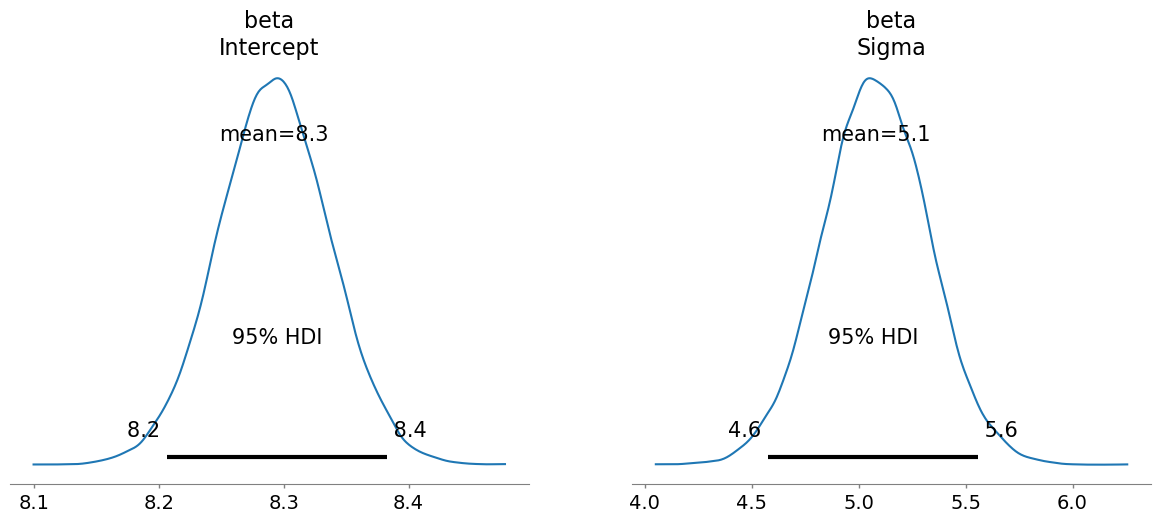

In [32]:
plt.figure()
az.plot_posterior(me_l_trace, var_names='beta', hdi_prob=0.95)
plt.show()

### Posterior Plot

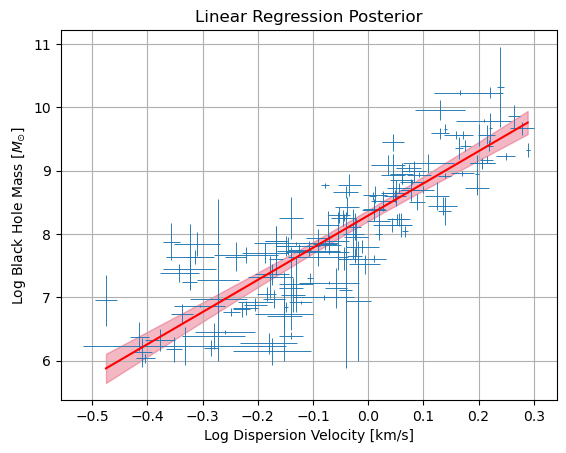

In [33]:
# Calculate quantiles for posterior black hole mass data
Y_mean = np.quantile(me_l_trace.posterior.mu.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(me_l_trace.posterior.mu.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(me_l_trace.posterior.mu.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Linear Regression Posterior')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

### Posterior Predictive Check

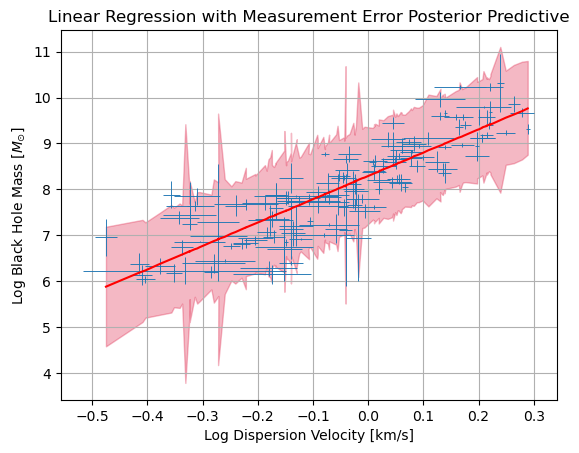

In [16]:
# Calculate quantiles for posterior predictive velocity dispersion data
X_mean = np.quantile(me_l_post_pred.posterior_predictive.X_obs.values, 0.50, axis=(0, 1))[:, 1]
X_lower = np.quantile(me_l_post_pred.posterior_predictive.X_obs.values, 0.025, axis=(0, 1))[:, 1]
X_upper = np.quantile(me_l_post_pred.posterior_predictive.X_obs.values, 0.975, axis=(0, 1))[:, 1]

# Calculate quantiles for posterior predictive black hole mass data
Y_mean = np.quantile(me_l_post_pred.posterior_predictive.Y_obs.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(me_l_post_pred.posterior_predictive.Y_obs.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(me_l_post_pred.posterior_predictive.Y_obs.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(X_mean, Y_mean, color='red', label='Best-fit Line')
plt.fill_between(X_mean, Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_between(np.sort(X_lower), Y_lower[np.argsort(X_lower)], Y_upper[np.argsort(X_lower)], color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_between(np.sort(X_upper), Y_lower[np.argsort(X_upper)], Y_upper[np.argsort(X_upper)], color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_betweenx(np.sort(Y_mean), X_lower[np.argsort(Y_mean)], X_upper[np.argsort(Y_mean)], color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Linear Regression with Measurement Error Posterior Predictive')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

# Quadratic Regression with Measurement Error

In [17]:
def me_quadratic_regression(X, Y, X_std, Y_std, c=1e-3, d=1e-3, e=0.5, f=0.5, samples=1000, draws=50):
    coords = {
        'galaxy': range(X.shape[0]),
        'parameters': ['Intercept', 'Sigma', 'Sigma^2'],
    }

    with pm.Model(coords=coords):
        tau = pm.Gamma('tau', alpha=e, beta=f)
        betas = pm.Normal('beta', mu=0, tau=d, dims='parameters')
        X_true = pm.Normal('X_true', mu=0, tau=c, dims=['galaxy', 'parameters'])
        X_obs = pm.Normal('X_obs', mu=X_true, sigma=X_std, observed=X)
        mu = pm.Deterministic('mu', X_obs @ betas)
        Y_true = pm.Normal('Y_true', mu=mu, tau=tau)
        Y_obs = pm.Normal('Y_obs', mu=Y_true, sigma=Y_std, observed=Y)

        # Sample posterior
        trace = pm.sample(samples)
        prior_pred = pm.sample_prior_predictive(draws=draws, random_seed=rng)
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
        return trace, prior_pred, post_pred

In [18]:
# Apply the quadratic regression model and show table of results
me_q_trace, me_q_prior_pred, me_q_post_pred = me_quadratic_regression(X_q, Y, X_q_err, Y_err)
pm.summary(me_q_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Intercept],8.199,0.056,8.103,8.312,0.001,0.001,5700.0,3044.0,1.0
beta[Sigma],5.501,0.291,4.992,6.084,0.003,0.002,8046.0,3318.0,1.0
beta[Sigma^2],3.400,1.230,1.168,5.694,0.015,0.011,6696.0,3418.0,1.0
"X_true[0, Intercept]",1.000,0.010,0.982,1.018,0.000,0.000,11360.0,2547.0,1.0
"X_true[0, Sigma]",-0.475,0.020,-0.512,-0.437,0.000,0.000,9361.0,2624.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[135],9.710,0.110,9.517,9.930,0.001,0.001,7834.0,3545.0,1.0
mu[136],9.781,0.117,9.574,10.009,0.001,0.001,7814.0,3579.0,1.0
mu[137],9.886,0.127,9.663,10.137,0.001,0.001,7800.0,3583.0,1.0
mu[138],9.997,0.138,9.751,10.265,0.002,0.001,7775.0,3513.0,1.0


<Figure size 640x480 with 0 Axes>

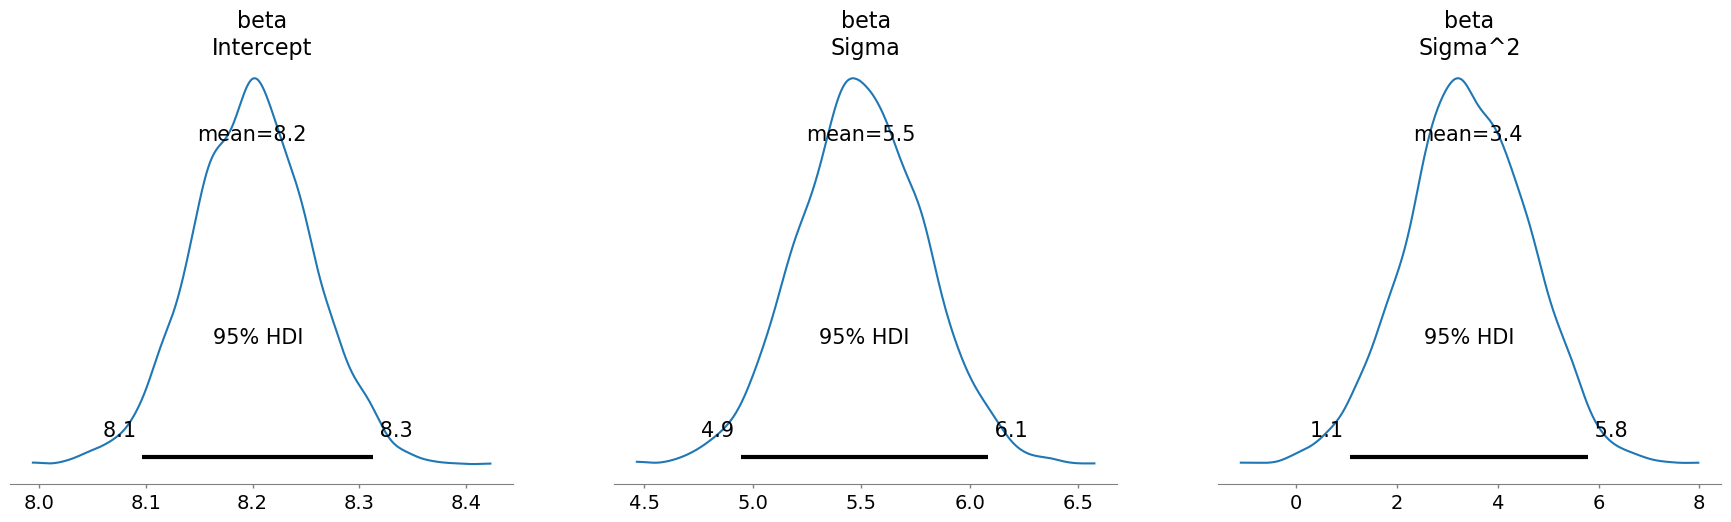

In [31]:
plt.figure()
az.plot_posterior(me_q_trace, var_names='beta', hdi_prob=0.95)
plt.show()

### Posterior Plot

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


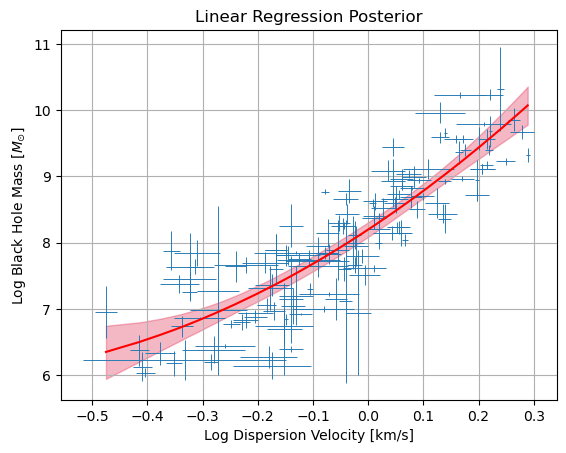

In [34]:
# Calculate quantiles for posterior black hole mass data
Y_mean = np.quantile(me_q_trace.posterior.mu.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(me_q_trace.posterior.mu.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(me_q_trace.posterior.mu.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Linear Regression Posterior')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

### Posterior Predictive Check

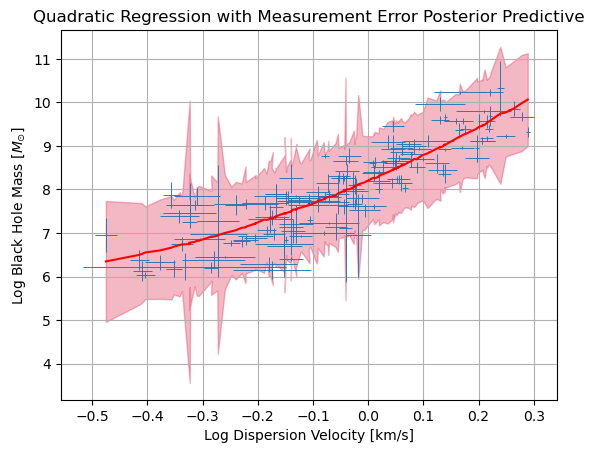

In [19]:
# Calculate quantiles for posterior predictive velocity dispersion data
X_mean = np.quantile(me_q_post_pred.posterior_predictive.X_obs.values, 0.50, axis=(0, 1))[:, 1]
X_lower = np.quantile(me_q_post_pred.posterior_predictive.X_obs.values, 0.025, axis=(0, 1))[:, 1]
X_upper = np.quantile(me_q_post_pred.posterior_predictive.X_obs.values, 0.975, axis=(0, 1))[:, 1]

# Calculate quantiles for posterior predictive black hole mass data
Y_mean = np.quantile(me_q_post_pred.posterior_predictive.Y_obs.values, 0.50, axis=(0, 1))
Y_lower = np.quantile(me_q_post_pred.posterior_predictive.Y_obs.values, 0.025, axis=(0, 1))
Y_upper = np.quantile(me_q_post_pred.posterior_predictive.Y_obs.values, 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.plot(X_mean, Y_mean, color='red', label='Best-fit Line')
plt.fill_between(X_mean, Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_between(np.sort(X_lower), Y_lower[np.argsort(X_lower)], Y_upper[np.argsort(X_lower)], color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_between(np.sort(X_upper), Y_lower[np.argsort(X_upper)], Y_upper[np.argsort(X_upper)], color='crimson', alpha=0.3, label="95% Credible Region")
# plt.fill_betweenx(np.sort(Y_mean), X_lower[np.argsort(Y_mean)], X_upper[np.argsort(Y_mean)], color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Quadratic Regression with Measurement Error Posterior Predictive')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

# Sensitivity Analysis

In [20]:
# c_opts = [1e-3, 1]
# d_opts = [1e-3, 1]
# e_opts = [0.1, 10]
# f_opts = [0.1, 10]
# s_me_l_trace = [[[[0 for i in range(len(c_opts))] for j in range(len(d_opts))] 
#                      for k in range(len(e_opts))] for l in range(len(f_opts))]
# s_me_l_prior_pred = s_me_l_trace
# s_me_l_post_pred = s_me_l_trace

# for ii, c in enumerate(c_opts):
#     for jj, d in enumerate(d_opts):
#         for kk, e in enumerate(e_opts):
#             for ll, f in enumerate(f_opts):
#                 print(f'Running with c={c}, d={d}, e={e}, f={f}')
#                 _trace, _prior_pred, _post_pred = me_linear_regression(X, Y, X_err, Y_err, c, d, e, f, samples=10000)
#                 s_me_l_trace[ii][jj][kk][ll] = _trace
#                 s_me_l_prior_pred[ii][jj][kk][ll] = _prior_pred
#                 s_me_l_post_pred[ii][jj][kk][ll] = _post_pred

In [21]:
# for ii, c in enumerate(c_opts):
#     for jj, d in enumerate(d_opts):
#         for kk, e in enumerate(e_opts):
#             for ll, f in enumerate(f_opts):
#                 # Calculate quantiles for posterior predictive velocity dispersion data
#                 X_mean = np.quantile(s_me_l_post_pred[ii][jj][kk][ll].posterior_predictive.X_obs.values, 0.50, axis=(0, 1))[:, 1]
#                 X_lower = np.quantile(s_me_l_post_pred[ii][jj][kk][ll].posterior_predictive.X_obs.values, 0.025, axis=(0, 1))[:, 1]
#                 X_upper = np.quantile(s_me_l_post_pred[ii][jj][kk][ll].posterior_predictive.X_obs.values, 0.975, axis=(0, 1))[:, 1]
                
#                 # Calculate quantiles for posterior predictive black hole mass data
#                 Y_mean = np.quantile(s_me_l_post_pred[ii][jj][kk][ll].posterior_predictive.Y_obs.values, 0.50, axis=(0, 1))
#                 Y_lower = np.quantile(s_me_l_post_pred[ii][jj][kk][ll].posterior_predictive.Y_obs.values, 0.025, axis=(0, 1))
#                 Y_upper = np.quantile(s_me_l_post_pred[ii][jj][kk][ll].posterior_predictive.Y_obs.values, 0.975, axis=(0, 1))
                
#                 plt.figure()
#                 plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
#                              data['e_log_sigma'], fmt='none', elinewidth=0.66)
#                 plt.plot(X_mean, Y_mean, color='red', label='Best-fit Line')
#                 plt.fill_between(X_mean, Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
#                 # plt.fill_between(np.sort(X_lower), Y_lower[np.argsort(X_lower)], Y_upper[np.argsort(X_lower)], color='crimson', alpha=0.3, label="95% Credible Region")
#                 # plt.fill_between(np.sort(X_upper), Y_lower[np.argsort(X_upper)], Y_upper[np.argsort(X_upper)], color='crimson', alpha=0.3, label="95% Credible Region")
#                 # plt.fill_betweenx(np.sort(Y_mean), X_lower[np.argsort(Y_mean)], X_upper[np.argsort(Y_mean)], color='crimson', alpha=0.3, label="95% Credible Region")
#                 plt.title(f'Linear Regression with Measurement Error Posterior Predictive \n c={c}, d={d}, e={e}, f={f}')
#                 plt.xlabel(r'Log Dispersion Velocity [km/s]')
#                 plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
#                 plt.grid()
#                 plt.show()

In [37]:
c_opts = [1e-5, 1e-2, 1e1]
d_opts = [1e-5, 1e-2, 1e1]
ss_me_l_trace = [[0 for i in range(len(c_opts))] for j in range(len(d_opts))]
ss_me_l_prior_pred = ss_me_l_trace
ss_me_l_post_pred = ss_me_l_trace

for ii, c in enumerate(c_opts):
    for jj, d in enumerate(d_opts):
        print(f'Running with c={c}, d={d}')
        _trace, _prior_pred, _post_pred = me_linear_regression(X, Y, X_err, Y_err, c, d, samples=1000)
        ss_me_l_trace[ii][jj] = _trace
        ss_me_l_prior_pred[ii][jj] = _prior_pred
        ss_me_l_post_pred[ii][jj] = _post_pred

Running with c=1e-05, d=1e-05


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Running with c=1e-05, d=0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Running with c=1e-05, d=10.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Running with c=0.01, d=1e-05


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Running with c=0.01, d=0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Running with c=0.01, d=10.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Running with c=10.0, d=1e-05


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Running with c=10.0, d=0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Running with c=10.0, d=10.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

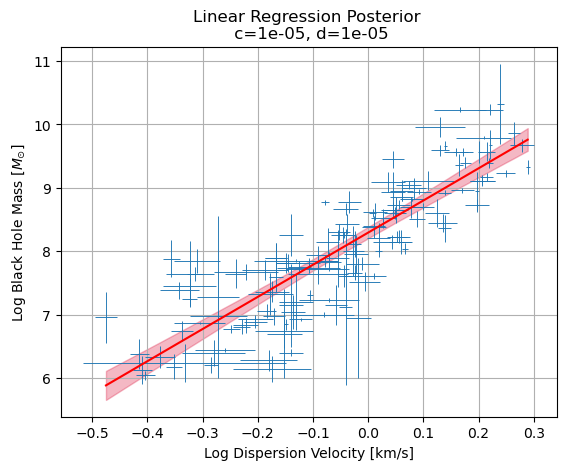

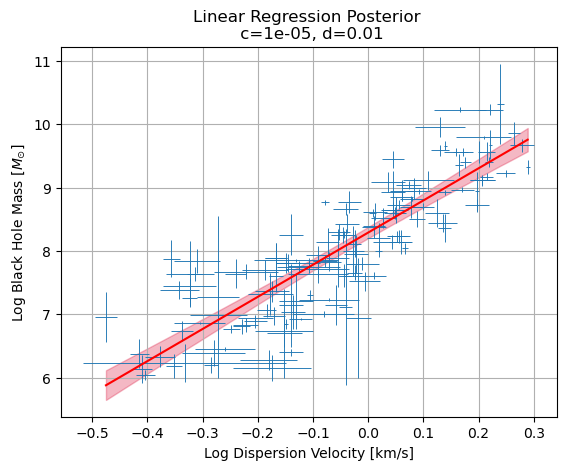

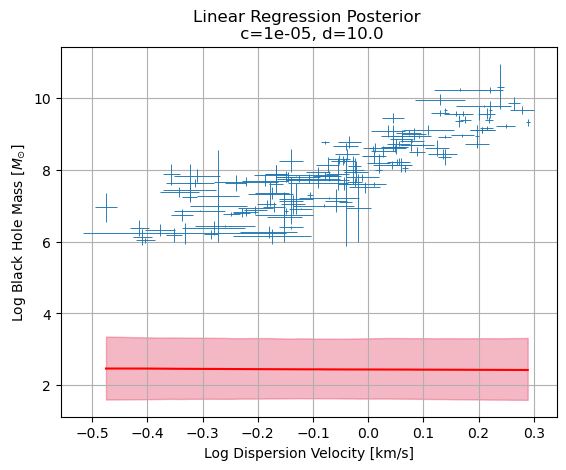

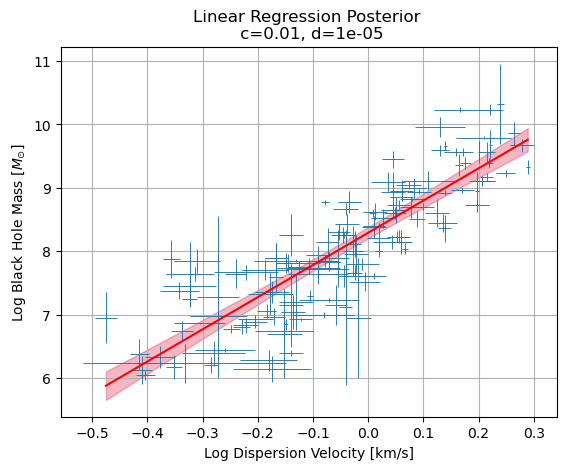

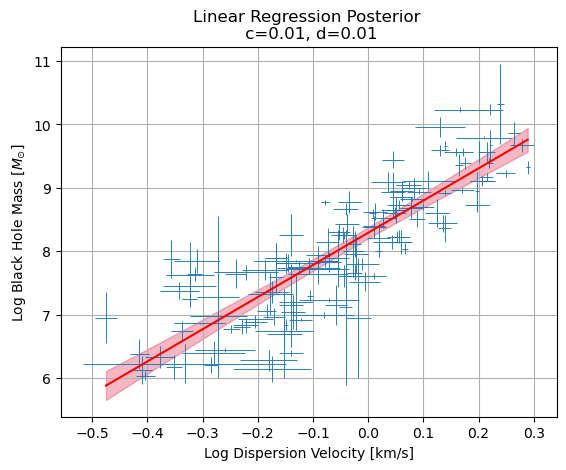

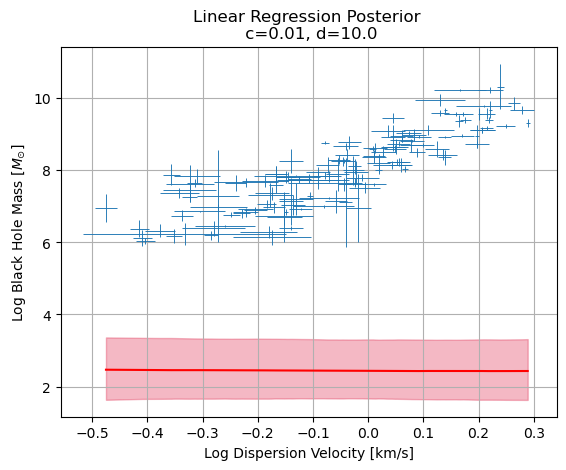

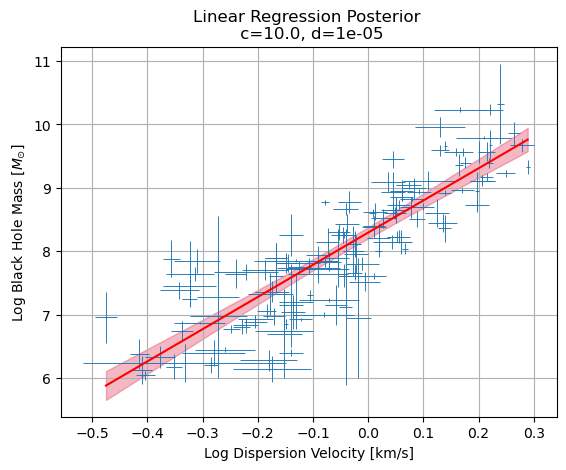

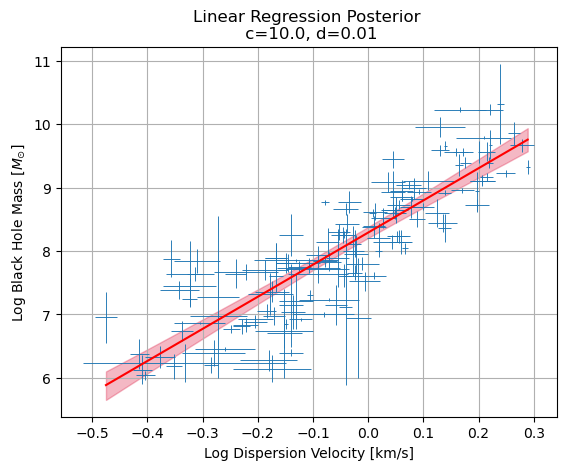

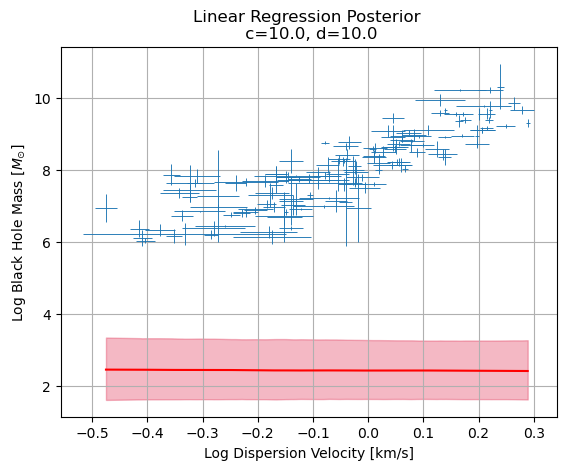

In [38]:
for ii, c in enumerate(c_opts):
    for jj, d in enumerate(d_opts):
        Y_mean = np.quantile(ss_me_l_trace[ii][jj].posterior.mu.values, 0.50, axis=(0, 1))
        Y_lower = np.quantile(ss_me_l_trace[ii][jj].posterior.mu.values, 0.025, axis=(0, 1))
        Y_upper = np.quantile(ss_me_l_trace[ii][jj].posterior.mu.values, 0.975, axis=(0, 1))
        
        plt.figure()
        plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
                     data['e_log_sigma'], fmt='none', elinewidth=0.66)
        plt.plot(data['log_sigma'], Y_mean, color='red', label='Best-fit Line')
        plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
        plt.title(f'Linear Regression Posterior \n c={c}, d={d}')
        plt.xlabel(r'Log Dispersion Velocity [km/s]')
        plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
        plt.grid()
        plt.show()